# This Notebook aims to analyse the eTraGo results with a focus on the gas sector

First findings:
- There is no storage expansion in the gas (CH4 + H2) sector. Already available CH4 storage capacities (7.34e+02 TWh) are only 61.1 % used (4.48e+02 TWh). The actual capacity band (maximum_current_energy_capacity - minimum_current_energy_capacity) used is only 1.68e+02 TWh meaning only 23 % of already available storage capacity is used.



TODO:
- wait for new results with new constrains and H2 feedin changes
- clear up gap between H2 generation and loads
- also work on Heat and AC?
- talk to FL about who analyzes what!
- Update Colors in plot.py
- make germany piechart map for generation of all major carriers (Heat, CH4, H2, AC)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from etrago import Etrago
from etrago import tools
from etrago.tools.plot import coloring

    'pyomo.core.expr.relational_expr.inequality'.  Please update your import.
    (deprecated in 6.4.3) (called from <frozen importlib._bootstrap>:219)


C:\ProgramData\mambaforge\envs\test\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\mambaforge\envs\test\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\mambaforge\envs\test\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization meth

In [3]:
# results from old optimization run; clustering folder is from other run and does not even represent the same number of clusters
colors = coloring
etrago = Etrago(csv_folder_name= "results_data1212_dsm_fix_eGon2035_300ac_80ch4")
network = etrago.network.copy()

INFO:pypsa.io:Imported network results_data1212_dsm_fix_eGon2035_300ac_80ch4 has buses, carriers, generators, lines, links, loads, storage_units, stores
C:\ProgramData\mambaforge\envs\test\lib\site-packages\pypsa\io.py:96: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  df["snapshot"] = pd.to_datetime(df.snapshot)
C:\ProgramData\mambaforge\envs\test\lib\site-packages\pypsa\io.py:110: DtypeWarning: Columns (0,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(fn, index_col=0, encoding=self.encoding)
INFO:pypsa.io:Imported network clustering has buses, lines, links


In [4]:
network.stores.carrier.unique()

array(['CH4', 'central_heat_store', 'rural_heat_store', 'H2_underground',
       'battery storage', 'dsm', 'H2_overground'], dtype=object)

In [5]:
network.buses.carrier.value_counts()

central_heat          504
central_heat_store    504
AC                    300
rural_heat_store      282
rural_heat            282
Li ion                282
dsm                   282
CH4                    80
H2_saltcavern          74
H2_grid                67
Name: carrier, dtype: int64

In [6]:
network.links.carrier.value_counts()

central_resistive_heater         552
industrial_gas_CHP               510
central_gas_boiler               505
central_heat_store_charger       504
central_heat_store_discharger    504
central_gas_CHP_heat             492
central_gas_CHP                  431
central_heat_pump                382
H2_to_power                      342
power_to_H2                      342
rural_heat_store_charger         282
rural_heat_store_discharger      282
dsm                              282
BEV charger                      282
rural_heat_pump                  282
CH4                              181
CH4_to_H2                         67
H2_feedin                         67
H2_to_CH4                         67
DC                                53
OCGT                              14
Name: carrier, dtype: int64

# CH4

<AxesSubplot: title={'center': 'CH4 Generation'}, xlabel='snapshot', ylabel='[GW]'>

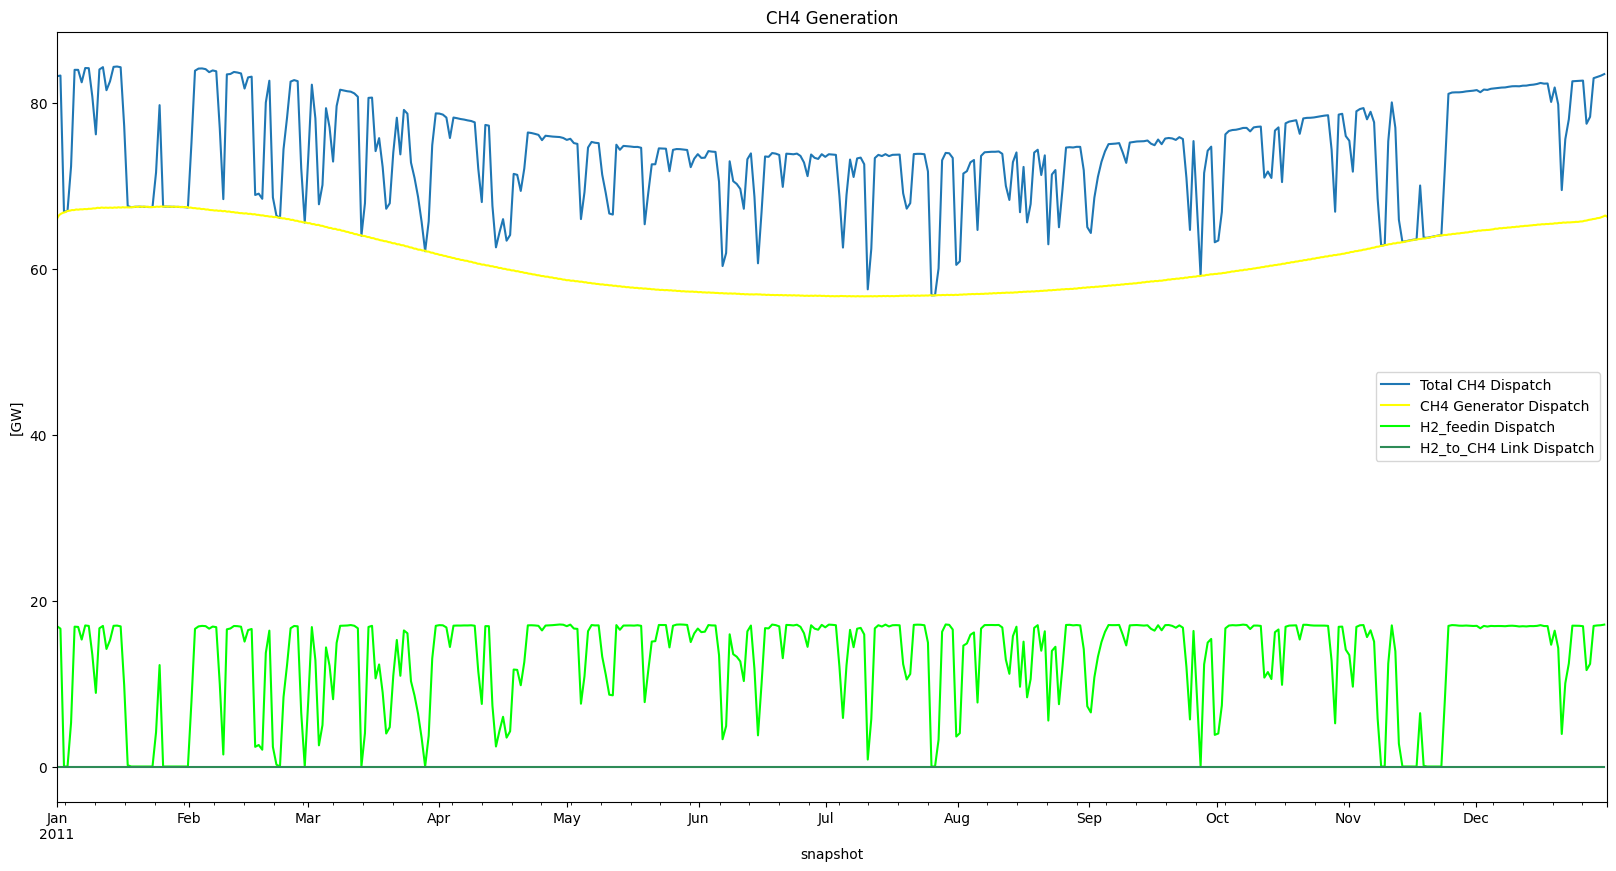

In [7]:
# Sources of CH4 over time?
# What are the possible sources?
# # # generators: 'CH4'
# # # links: 'H2_to_CH4', 'H2_feedin'
# stores not included because they dont generatre CH4
"""##### WHAT IS '''''Generator_biomass', 'Generator_gas'''?????????????###########"""

ch4_gens_feedin = network.generators_t.p[[col for col in network.generators_t.p.columns if 'CH4' in col]] # active power at bus
ch4_links_feedin = -network.links_t.p1[network.links.loc[network.links.carrier == 'H2_to_CH4'].index] #p1 is output p of H2_to_CH4
h2_links_feedin = -network.links_t.p1[network.links.loc[network.links.carrier == 'H2_feedin'].index]
# ch4_stores_feedin = network.stores_t.p[[col for col in network.stores_t.p.columns if 'CH4' in col]]

total_gen_per_t = ch4_gens_feedin.sum(axis = 1)/1e3
total_link_per_t = ch4_links_feedin.sum(axis = 1)/1e3
total_h2_per_t = h2_links_feedin.sum(axis=1)/1e3
# total_store_per_t = ch4_stores_feedin.sum(axis = 1)
# question: is H2_to_CH4 really that low or is there a conversion error?

a = (total_gen_per_t + total_link_per_t + total_h2_per_t).resample('20H').mean().plot(figsize = (20,10), title = "CH4 Generation", legend=True, ylabel = "[GW]", label = 'Total CH4 Dispatch')
total_gen_per_t.plot(ax = a, label = "CH4 Generator Dispatch", legend=True, color = colors()['CH4'])
total_h2_per_t.resample('20H').mean().plot(ax = a, label = "H2_feedin Dispatch", legend=True, color = colors()['H2_feedin'])
total_link_per_t.resample('20H').mean().plot(ax = a, label = "H2_to_CH4 Link Dispatch", legend=True, color = colors()['H2_to_CH4'])

#### Where is the CH4 generated?

(<matplotlib.collections.PatchCollection at 0x176afcbcbe0>,
 <matplotlib.collections.LineCollection at 0x176bb65d2e0>)

C:\ProgramData\mambaforge\envs\test\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\ProgramData\mambaforge\envs\test\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


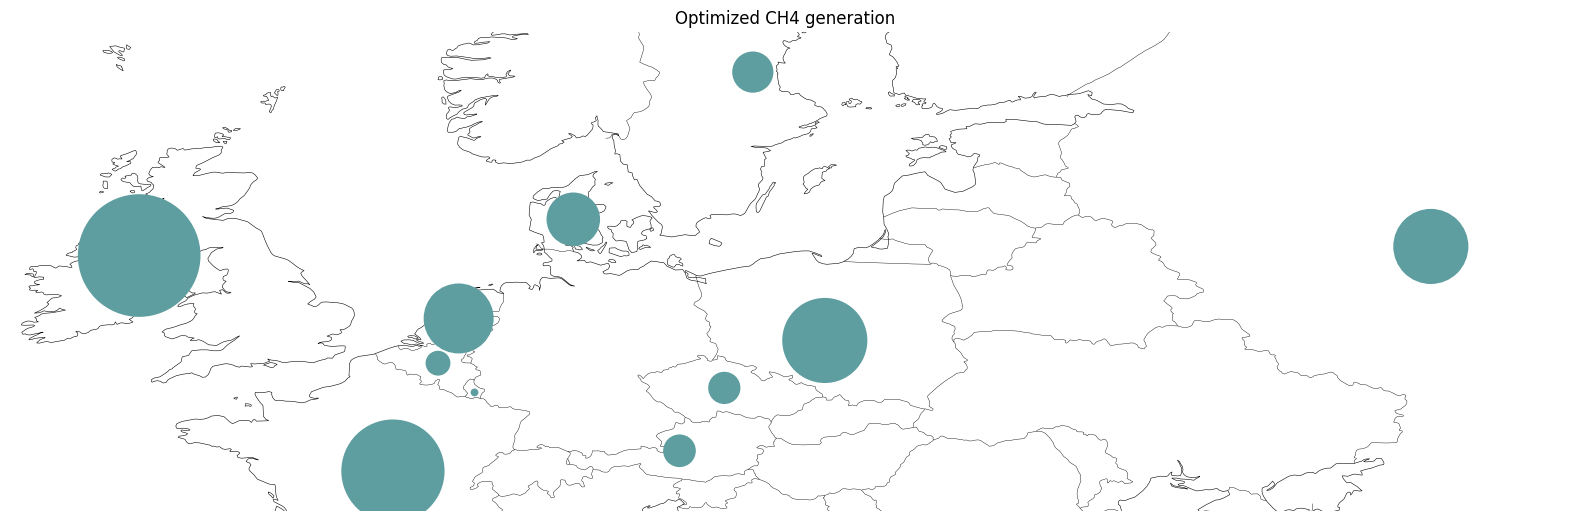

In [8]:
ch4_gen = network.generators.loc[network.generators.carrier == 'CH4']
capacities = network.generators_t.p[ch4_gen.index].sum(axis=0)

# remove 'CH4' from index to be able to use network.plot
new_idx = [i.replace(' CH4','') for i in capacities.index.to_list()]
capacities = pd.Series(capacities.values,index = new_idx)
scaling = 1/capacities.max()

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (20,10))
network.plot(
    bus_sizes=capacities * (scaling*5),
    #bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "Optimized CH4 generation")

In [9]:
capacities
# Significant foreign CH4 production capacities are located in FR, BE and SWE 

48621    2.055285e+06
48622    1.187629e+06
48624    2.006387e+06
48625    5.524839e+06
48626    2.053785e+07
48627    2.898737e+07
48628    1.163491e+05
48629    9.436053e+06
48631    1.395630e+07
48632    3.271872e+06
48634    1.087015e+07
dtype: float64

In [10]:
# Why is there only Gas Produced in FR, BE and SWE? Why not RUS
# Because of Biogas/Natural Gas prices? What about Gas in North Sea / NO? 
# Maybe problem of kmeans clustering?

#### What is the CH4 used for?

In [11]:
# Use over CH4 over time (loads)
# What are the loads?
Links:
'industrial_gas_CHP', 'OCGT', 'CH4_to_H2', 'central_gas_CHP_heat','central_gas_boiler', 'rural_gas_boiler'
check:
'central_heat_store_charger', 'central_heat_store_discharger',
'rural_heat_store_charger', 'rural_heat_store_discharger']

Loads:
'CH4'

Generator:
'Generator_geo_thermal'
'Generator_central_biomass_CHP'
'Generator_central_biomass_CHP_heat'
'Generator_industrial_biomass_CHP'
'Generator_biomass'
'Generator_gas'
# Check modelling diagram

SyntaxError: invalid syntax (1498723303.py, line 3)

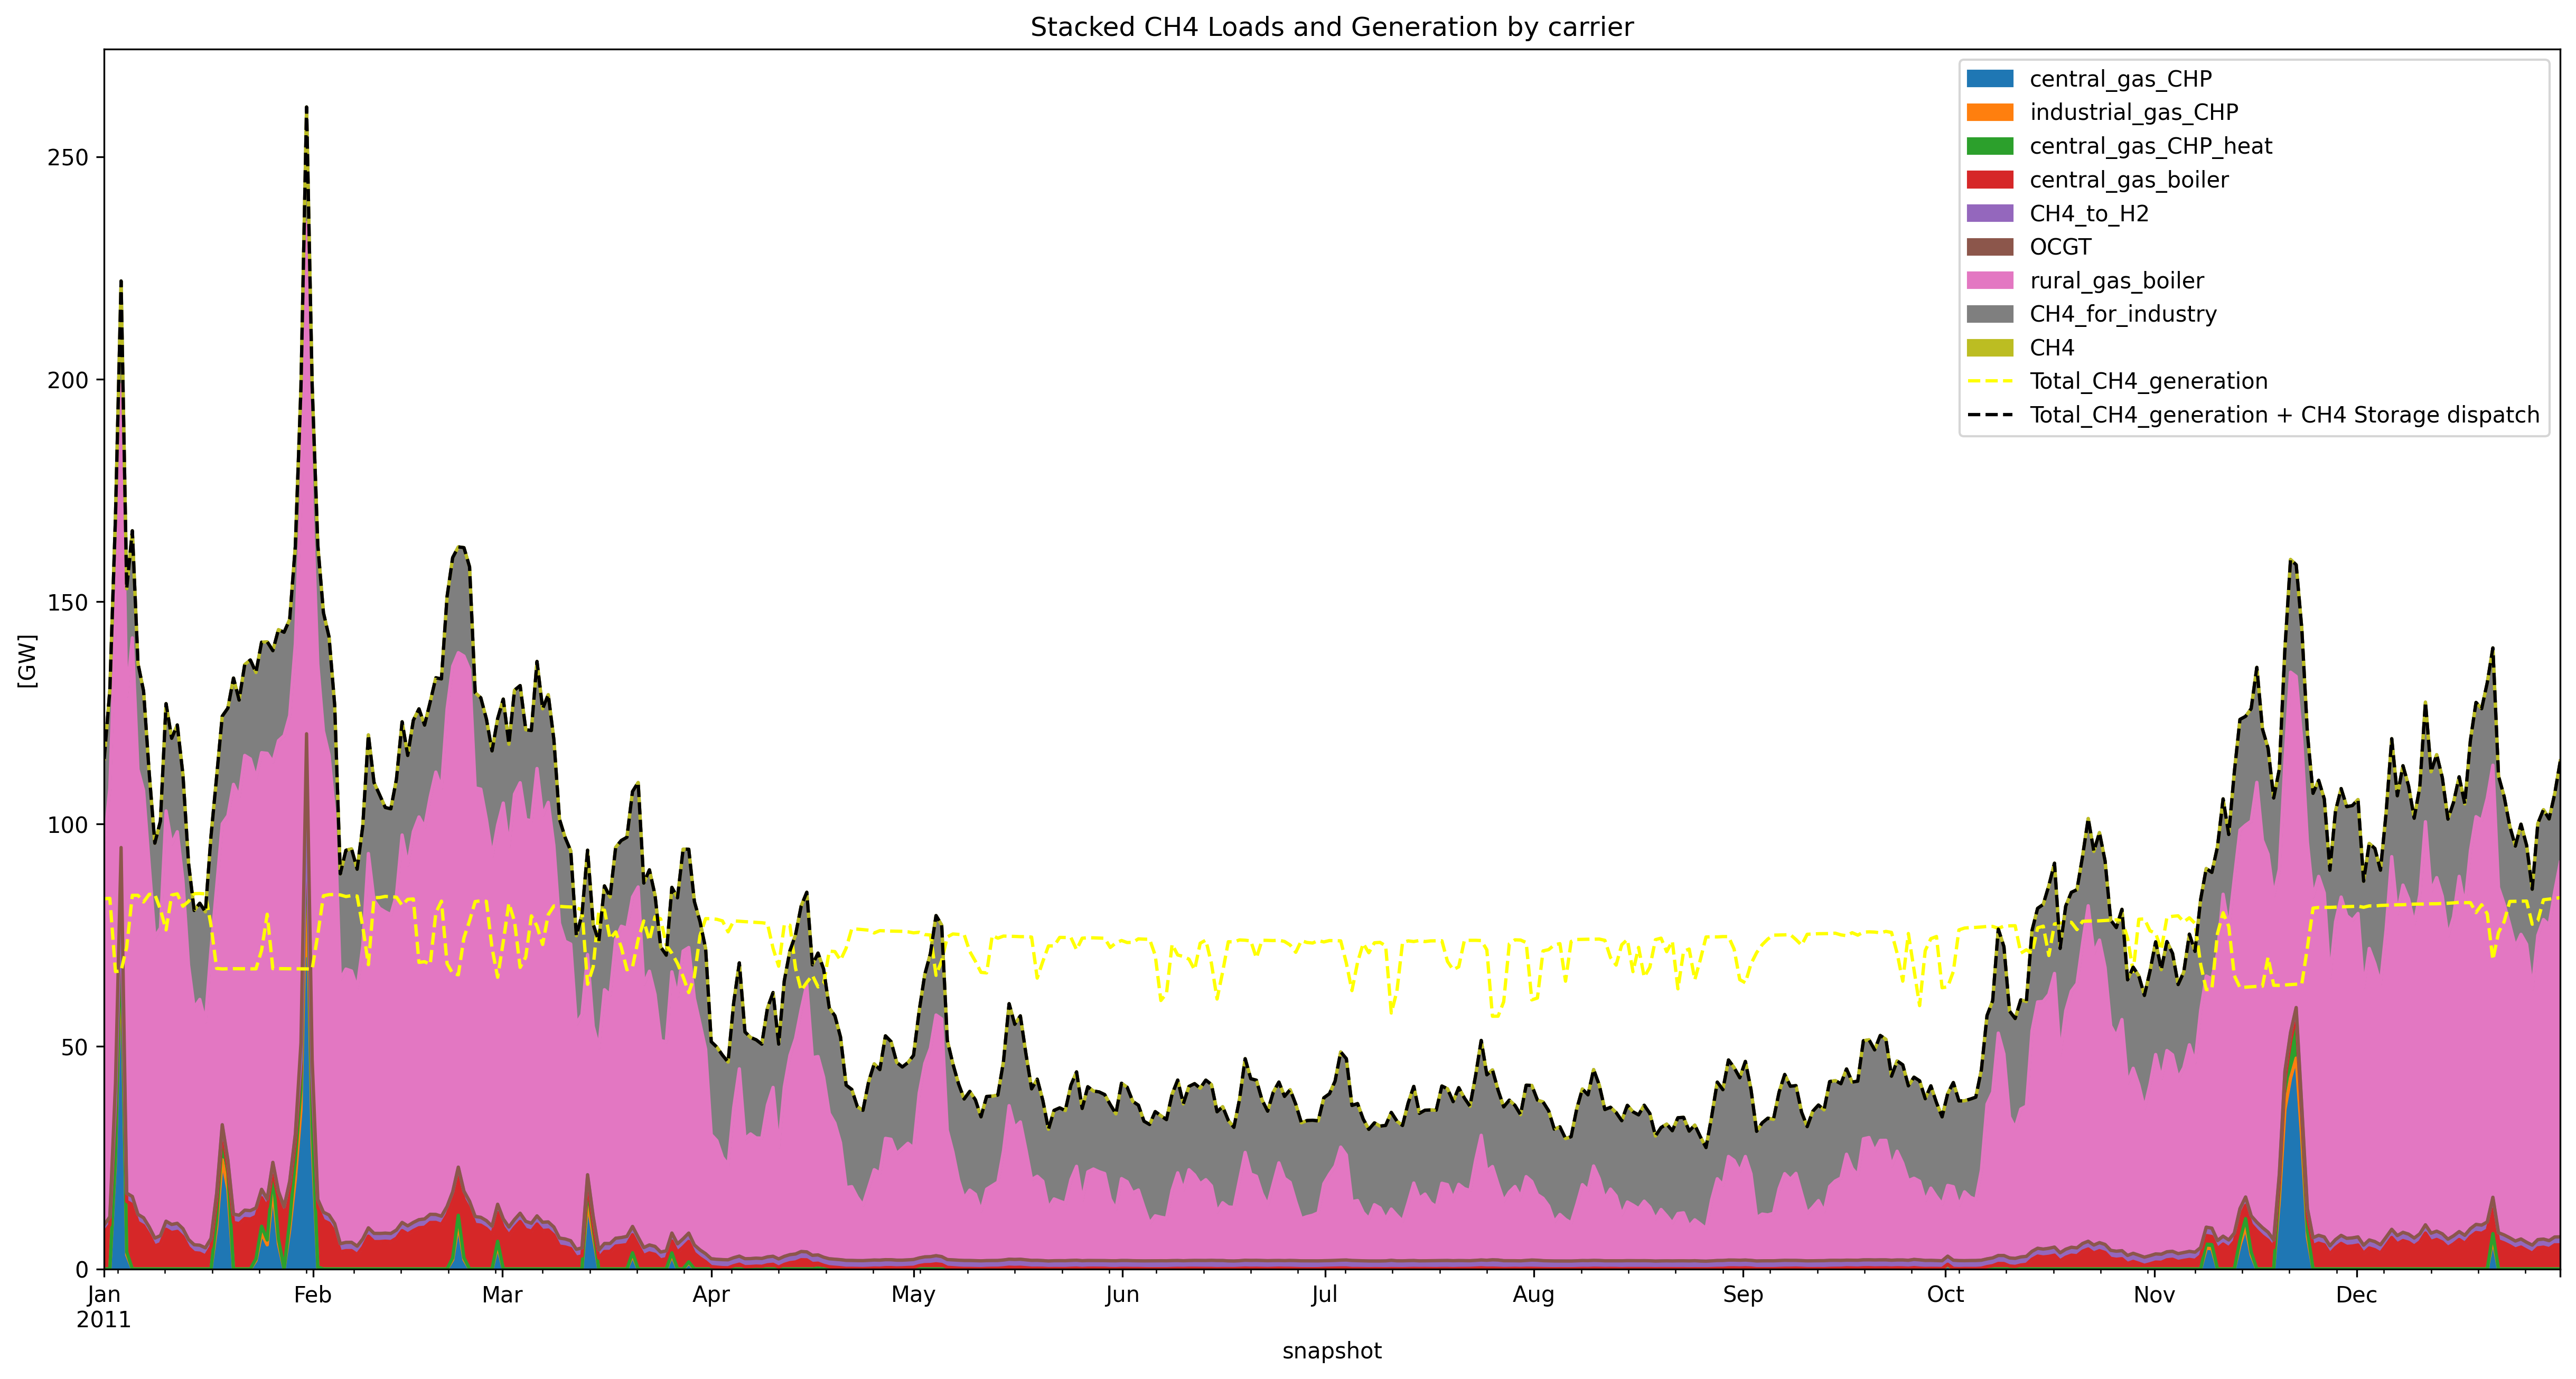

In [12]:
### CH4 related technologies ###

### Plot stacked CH4 related link loads ###
rel_ch4_loads = network.links.loc[network.links.bus0.isin(network.buses.loc[network.buses.carrier == 'CH4'].index)].carrier.unique()
rel_ch4_loads = np.delete(rel_ch4_loads, np.where(rel_ch4_loads == 'CH4'))

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_ch4_loads[0]].index.to_list()]
data = pd.DataFrame(data.sum(axis=1)).resample('20H').mean()/1e3
data = data.rename(columns={0:rel_ch4_loads[0]})

for i in rel_ch4_loads[1:]:
    loads = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

### add ch4 network.loads ###
ch4_load_carrier = ['rural_gas_boiler', 'CH4_for_industry', 'CH4']
for i in ch4_load_carrier:
    loads = network.loads_t.p[network.loads.loc[network.loads.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

fig = plt.figure(figsize=(20, 10), dpi=300)
data.plot.area(ax = plt.gca(), title='Stacked CH4 Loads and Generation by carrier', ylabel = "[GW]", legend=True, stacked=True)

(total_gen_per_t + total_link_per_t + total_h2_per_t).resample('20H').mean().plot.line(legend=True, label = 'Total_CH4_generation',  color = colors()['CH4'], linestyle='dashed')

stores=network.stores.loc[network.stores.carrier=='CH4']
a = (network.stores_t.p[stores.index].sum(axis=1)/1e3)
(total_gen_per_t + total_link_per_t + total_h2_per_t + a).resample('20H').mean().plot.line(legend=True, label = 'Total_CH4_generation + CH4 Storage dispatch',  color = 'black', linestyle='dashed')

fig.savefig('asdf_CH4')

In [13]:
data.sum().sum()
(total_gen_per_t + total_link_per_t + total_h2_per_t).resample('20H').mean().sum()
# is equal so all loads are covered by dispatch

32466.102423537588

<AxesSubplot: xlabel='snapshot'>

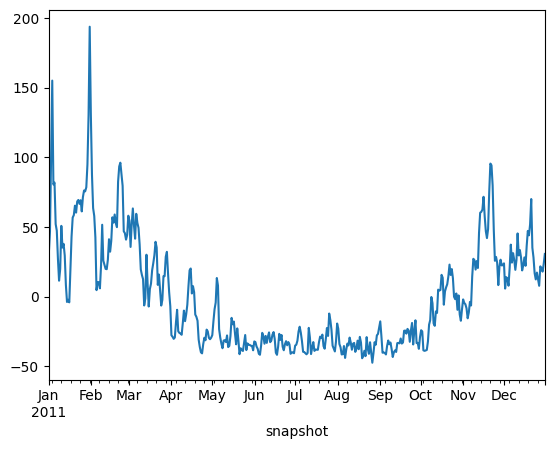

In [14]:
stores=network.stores.loc[network.stores.carrier=='CH4']
(network.stores_t.p[stores.index].sum(axis=1)/1e3).resample('20H').mean().plot()

Maximum mean dispatch over 20H
central_gas_CHP: 69.71406847215688
industrial_gas_CHP: 21.761899598411052
central_gas_CHP_heat: 9.823050283924413
central_gas_boiler: 14.470766233904628
CH4_to_H2: 1.8825072342088598
OCGT: 15.461428510080728
rural_gas_boiler: 125.58971746842904
CH4_for_industry: 27.615070595549422
CH4: 0.054010317010443336


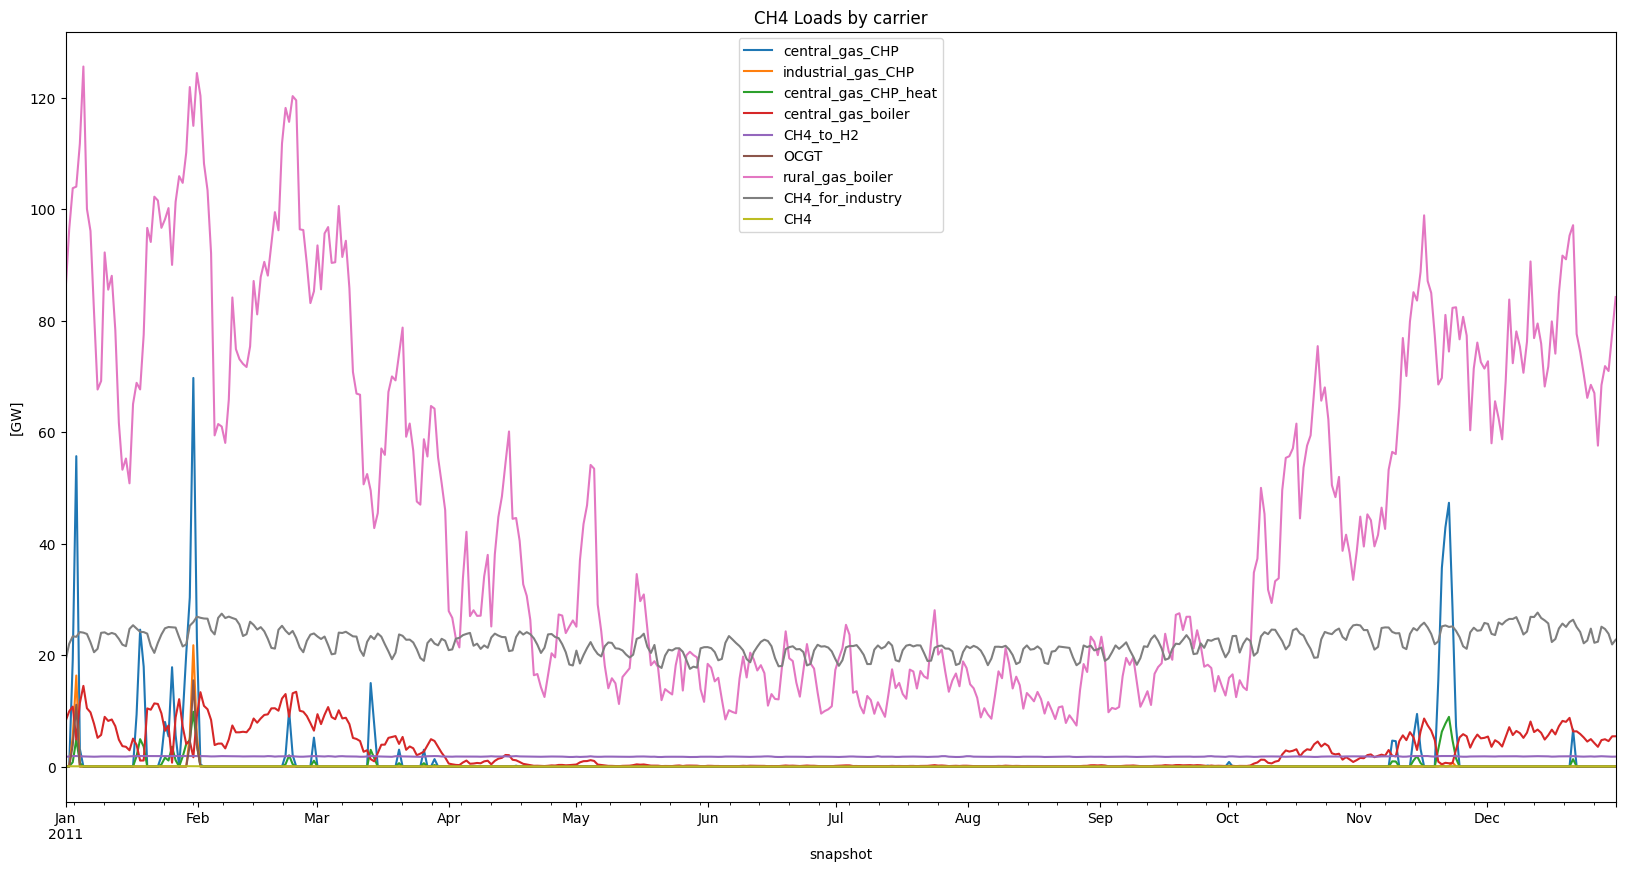

In [15]:
### CH4 related technologies ###
### plot non-stacked CH4 related link loads and loads

rel_ch4_loads = network.links.loc[network.links.bus0.isin(network.buses.loc[network.buses.carrier == 'CH4'].index)].carrier.unique()
rel_ch4_loads = np.delete(rel_ch4_loads, np.where(rel_ch4_loads == 'CH4'))

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_ch4_loads[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
plot = data.plot(figsize=(20, 10), title='CH4 Loads by carrier', label = rel_ch4_loads[0], ylabel = "[GW]", legend=True)

print('Maximum mean dispatch over 20H')
print(f'{rel_ch4_loads[0]}: {data.max()}')

for i in rel_ch4_loads[1:]:
    data = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data = data.sum(axis=1).resample('20H').mean()/1e3
    data.plot(ax = plot, label = i, legend=True)
    print(f'{i}: {data.max()}')

data = network.loads_t.p[network.loads.loc[network.loads.carrier == ch4_load_carrier[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
data.plot(ax=plot, label = ch4_load_carrier[0], ylabel = "[GW]", legend=True)
print(f'{ch4_load_carrier[0]}: {data.max()}')

for i in ch4_load_carrier[1:]:
    data = network.loads_t.p[network.loads.loc[network.loads.carrier == i].index.to_list()]
    data = data.sum(axis=1).resample('20H').mean()/1e3
    data.plot(ax = plot, label = i, legend=True)
    print(f'{i}: {data.max()}')

- All carriers show strong seasonal behaviour except for 'CH4_to_H2' which provides small continuous demand the whole year around
- 'OCGT' have only two significant temporal intervals where they are put to use

# H2

<AxesSubplot: title={'center': 'H2 Generation'}, xlabel='snapshot', ylabel='[GW]'>

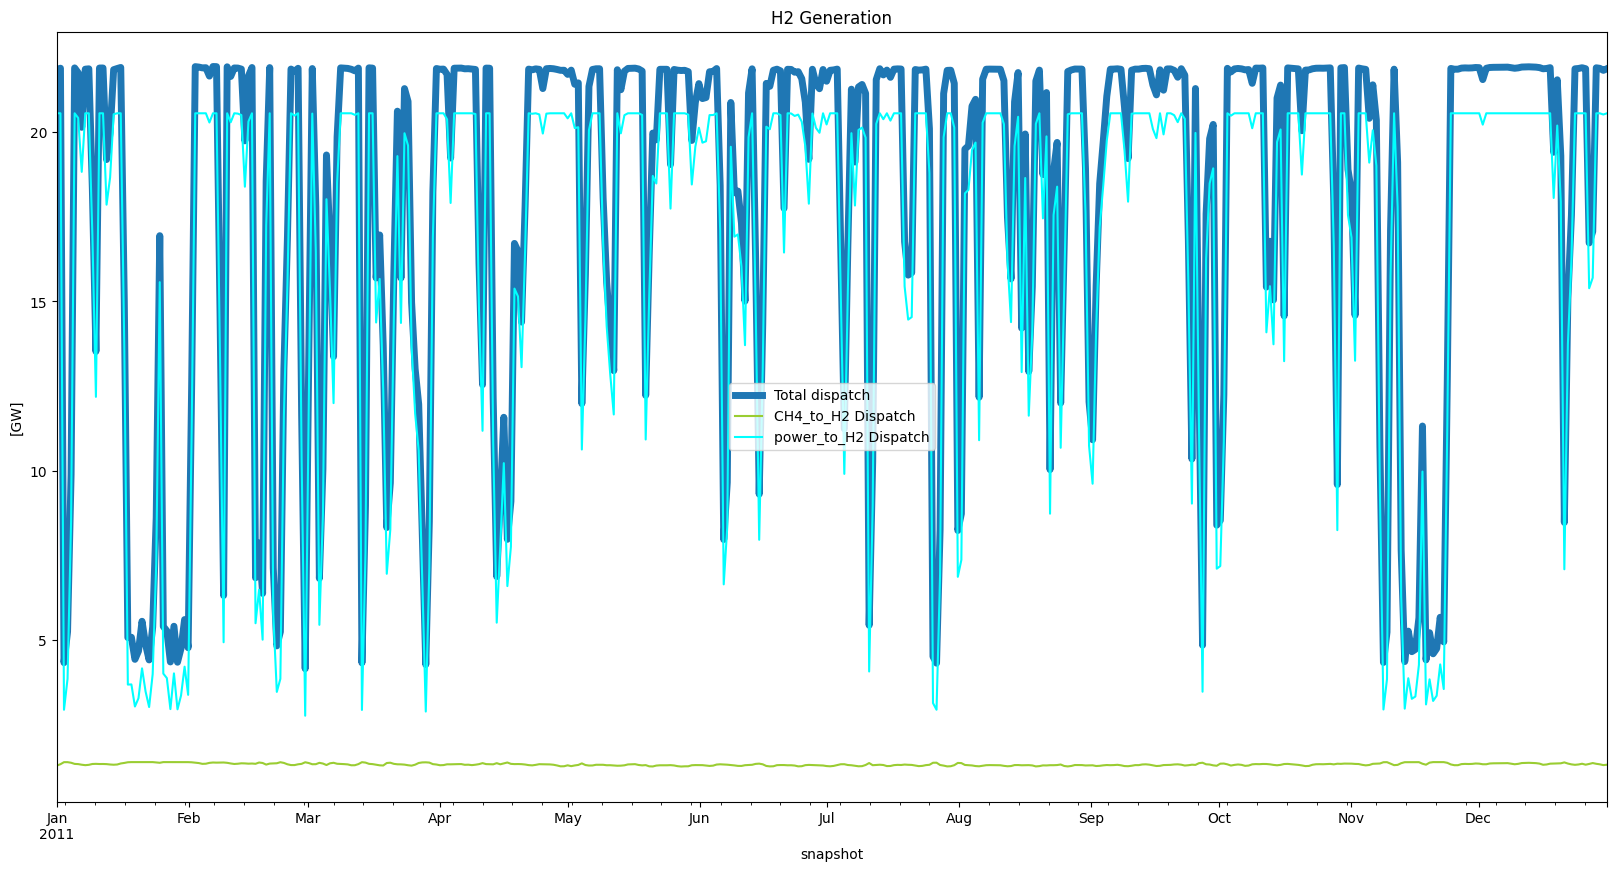

In [48]:
# Sources of H2 over time?
# What are the possible sources?
# # # links: 'power_to_H2', 'CH4_to_H2'
# stores not included because they dont generate H2

h2_CH4_gen = -network.links_t.p1[network.links.loc[network.links.carrier == 'CH4_to_H2'].index]
h2_power_gen = -network.links_t.p1[network.links.loc[network.links.carrier == 'power_to_H2'].index]

a = (h2_CH4_gen.sum(axis = 1)/1e3 + h2_power_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(figsize = (20,10), title = "H2 Generation", legend=True, ylabel = "[GW]", label = 'Total dispatch', lw=5)
(h2_CH4_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(ax = a, label = "CH4_to_H2 Dispatch", legend=True, color = colors()['CH4_to_H2'])
(h2_power_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(ax = a, label = "power_to_H2 Dispatch", legend=True, color = colors()['power_to_H2'])

## Where is the H2 generated?

In [17]:
capacitiesCH4_H2 = pd.Series(h2_CH4_gen.sum().values, index = network.links.loc[h2_CH4_gen.sum().index].bus1.values)

capacitiesPower_H2 = pd.Series(h2_power_gen.sum().values, index = network.links.loc[h2_power_gen.sum().index].bus1.values)
capacitiesPower_H2 = capacitiesPower_H2.groupby(capacitiesPower_H2.index).sum()

H2_grid_capacities = capacitiesCH4_H2 + capacitiesPower_H2.loc[network.buses.loc[network.buses.carrier == 'H2_grid'].index]
H2_saltcavern_capacities = capacitiesPower_H2.loc[network.buses.loc[network.buses.carrier == 'H2_saltcavern'].index]

(<matplotlib.collections.PatchCollection at 0x176c612f730>,
 <matplotlib.collections.LineCollection at 0x176d067fca0>)

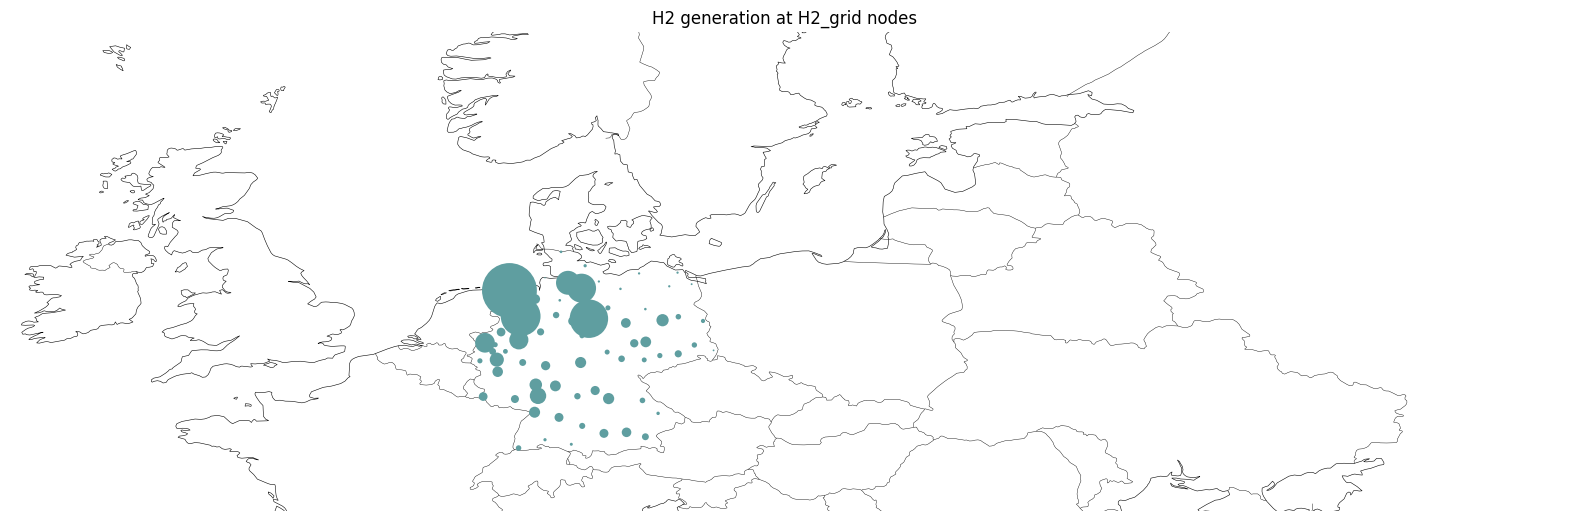

In [18]:
scaling = 1/H2_grid_capacities.max()

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (20,10))
network.plot(
    bus_sizes=H2_grid_capacities*scaling,
    #bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "H2 generation at H2_grid nodes")

(<matplotlib.collections.PatchCollection at 0x176d03a9f70>,
 <matplotlib.collections.LineCollection at 0x176d02fef10>)

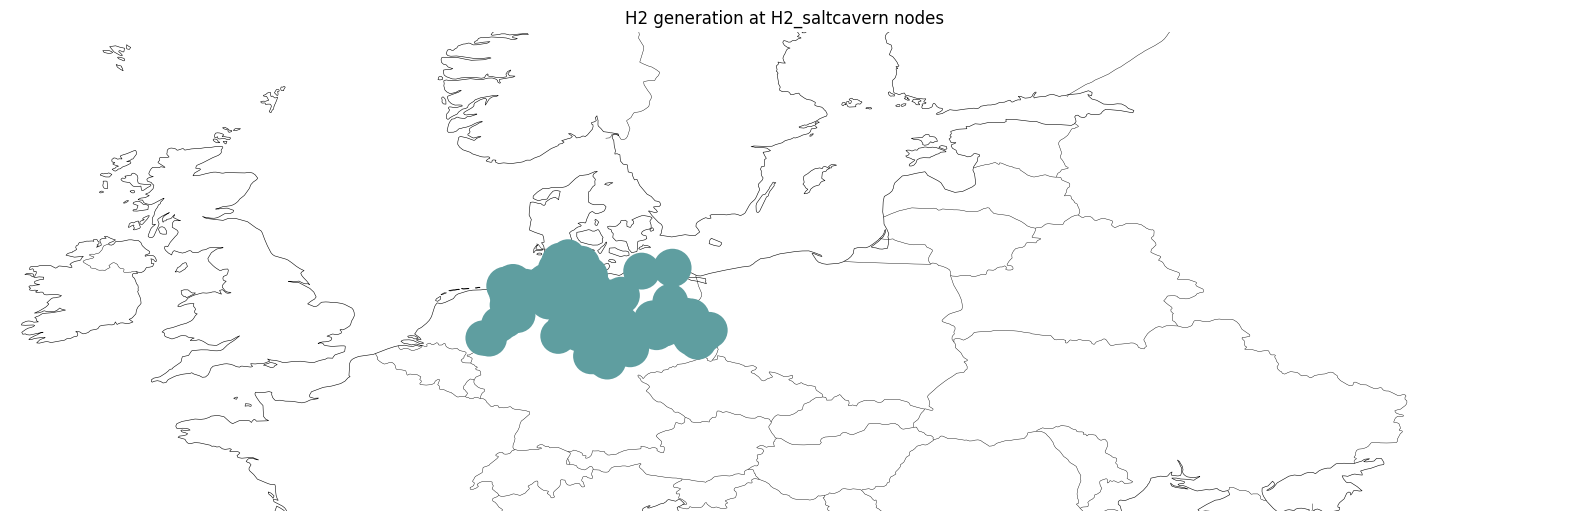

In [19]:
scaling = 1/H2_saltcavern_capacities.max()

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (20,10))
network.plot(
    bus_sizes=H2_saltcavern_capacities*scaling*.5,
    #bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "H2 generation at H2_saltcavern nodes")

## What is H2 used for?

In [20]:
h2_stores = network.stores.loc[network.stores.carrier.isin(['H2_underground', 'H2_overground'])]
h2_stores_dispatch = network.stores_t.p[h2_stores.index].sum(axis=1)

<AxesSubplot: xlabel='snapshot'>

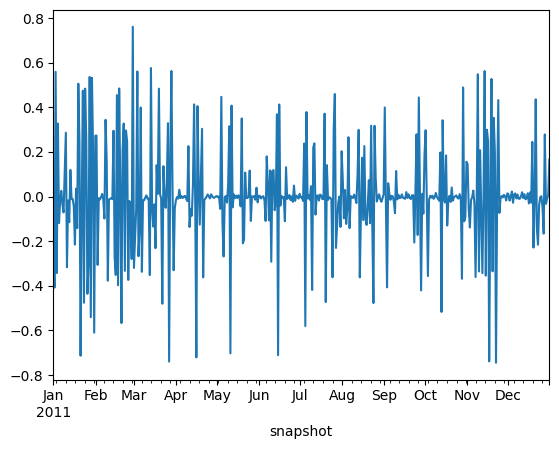

In [21]:
(h2_stores_dispatch/1e3).resample('20H').mean().plot()

<AxesSubplot: title={'center': 'Stacked H2 Loads by carrier'}, xlabel='snapshot', ylabel='[GW]'>

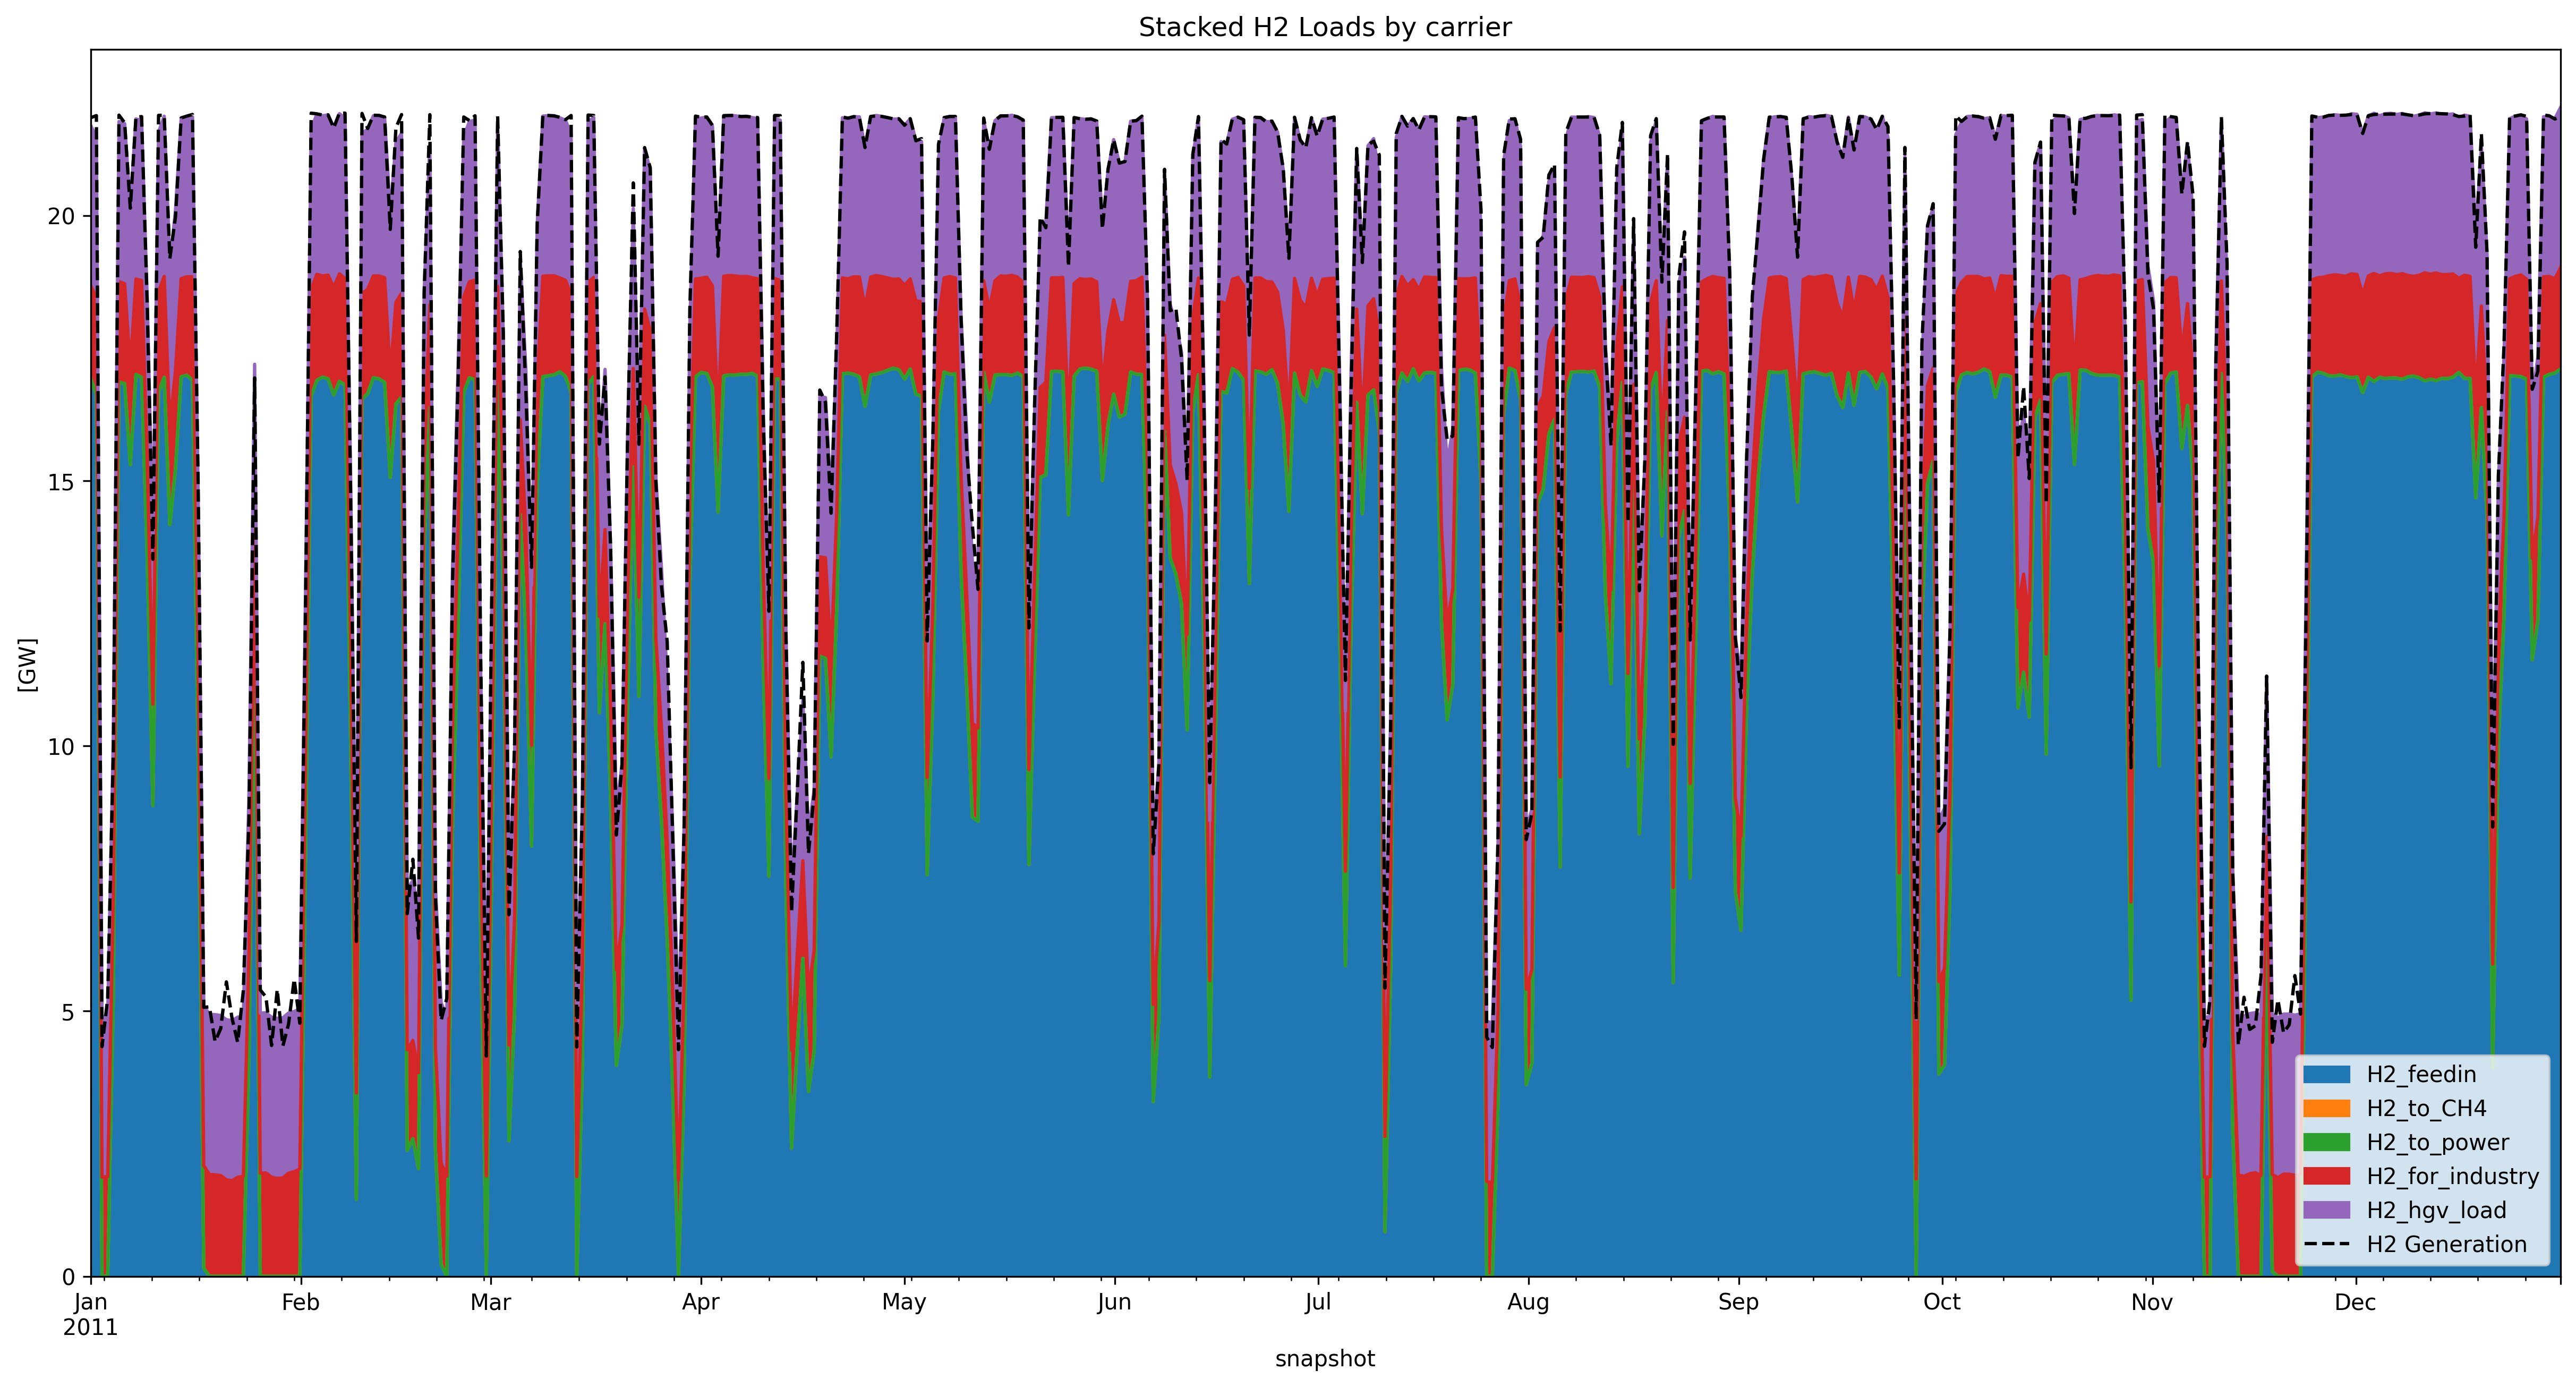

In [22]:
### H2 related technologies ###
# network.loads: 'H2_for_industry', 'H2_hgv_load'
# network links: 'H2_feedin', 'H2_to_CH4', 'H2_to_power'

### Plot stacked H2 related link loads ###
rel_h2_links = ['H2_feedin', 'H2_to_CH4', 'H2_to_power']

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_h2_links[0]].index.to_list()]
data = pd.DataFrame(data.sum(axis=1)).resample('20H').mean()/1e3
data = data.rename(columns={0:rel_h2_links[0]})

for i in rel_h2_links[1:]:
    loads = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

### add ch4 network.loads ###
rel_h2_loads = ['H2_for_industry', 'H2_hgv_load']

DE_loads = network.loads.loc[network.loads.bus.isin(network.buses.loc[network.buses.country == 'DE'].index)]
for i in rel_h2_loads:
    loads = network.loads_t.p[DE_loads.loc[DE_loads.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

fig = plt.figure(figsize=(20, 10), dpi=300)
data.plot.area(ax = plt.gca(), title='Stacked H2 Loads by carrier', ylabel = "[GW]", legend=True, stacked=True)

(h2_CH4_gen.sum(axis = 1)/1e3 + h2_power_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(ax = plt.gca(), legend = True, label='H2 Generation', color='black', linestyle='dashed')

# What is missing in the generation? Where does the difference come from?

In [54]:
network.links.loc[network.links.carrier == 'H2_feedin'].p_nom_opt.sum() / 1e3

910.9257984909653

Maximum mean dispatch over 20H
H2_feedin: 17.126012820200142
H2_to_CH4: 3.262603338200327e-07
H2_to_power: 5.881908342768254e-07
H2_for_industry: 2.0373848941753


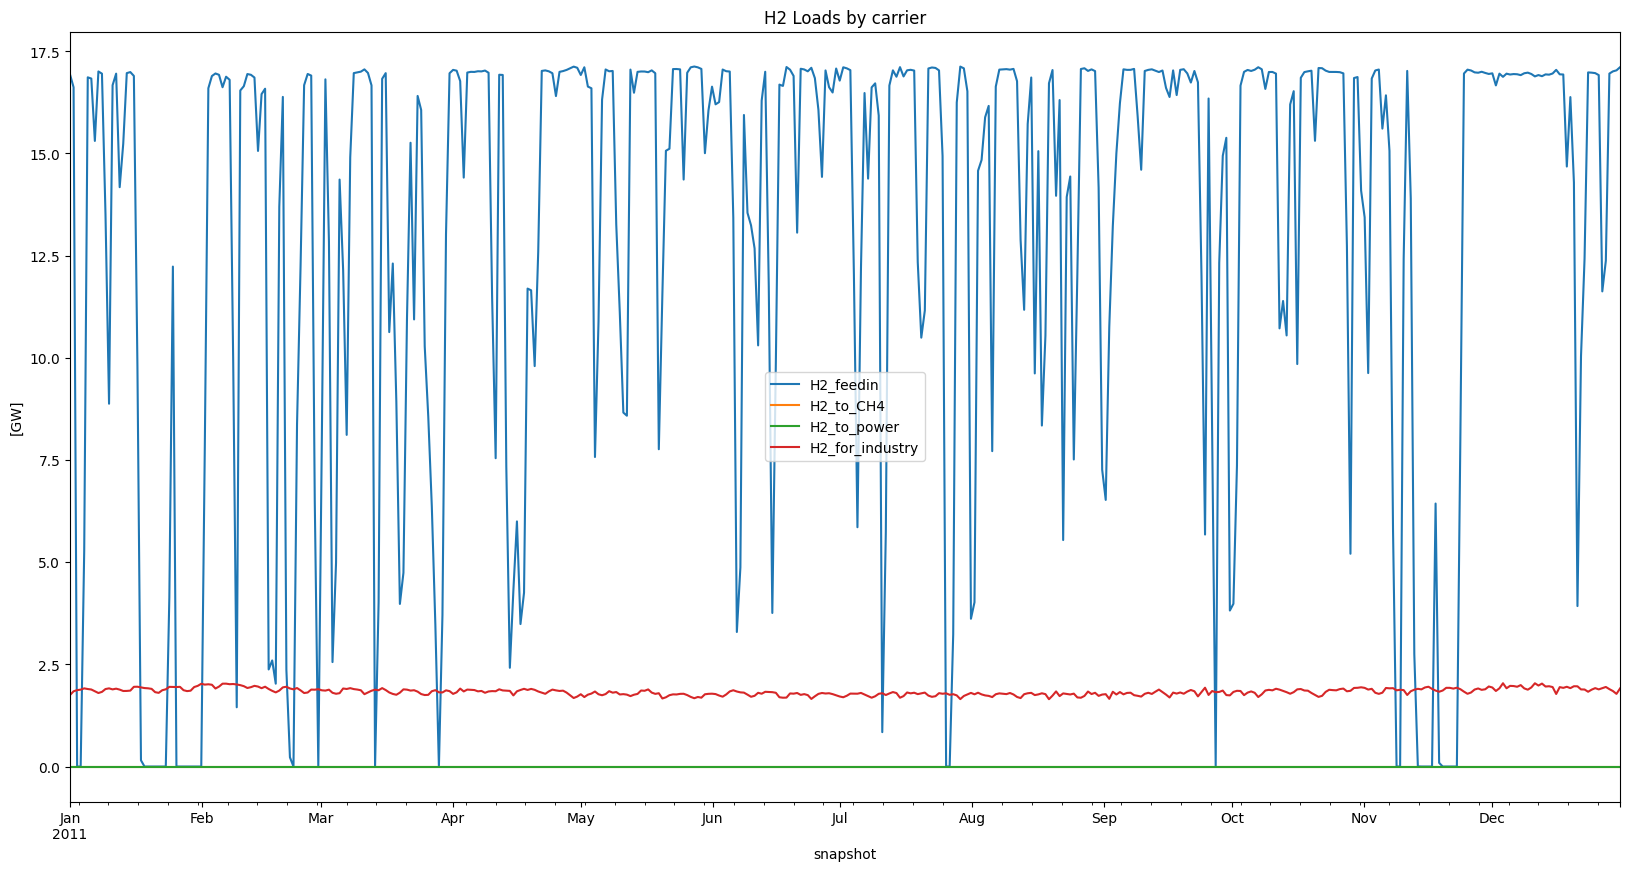

In [23]:
### H2 related technologies ###
### plot non-stacked H2 related link loads and loads

rel_h2_links = ['H2_feedin', 'H2_to_CH4', 'H2_to_power']

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_h2_links[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
plot = data.plot(figsize=(20, 10), title='H2 Loads by carrier', label = rel_h2_links[0], ylabel = "[GW]", legend=True)

print('Maximum mean dispatch over 20H')
print(f'{rel_h2_links[0]}: {data.max()}')

for i in rel_h2_links[1:]:
    data = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data = data.sum(axis=1).resample('20H').mean()/1e3
    data.plot(ax = plot, label = i, legend=True)
    print(f'{i}: {data.max()}')

DE_loads = network.loads.loc[network.loads.bus.isin(network.buses.loc[network.buses.country == 'DE'].index)]
data = network.loads_t.p[DE_loads.loc[DE_loads.carrier == rel_h2_loads[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
data.plot(ax=plot, label = rel_h2_loads[0], ylabel = "[GW]", legend=True)
print(f'{rel_h2_loads[0]}: {data.max()}')

# Investigate Gas (CH4, H2) Storages

CH4 total storage capacity:7.34e+02 TWh
CH4 Maximum fill (%): 62.0
H2_overground total storage capacity:0.0153 TWh
H2_overground Maximum fill (%): 99.9
H2_underground total storage capacity:7.59e-07 TWh
H2_underground Maximum fill (%): 56.3


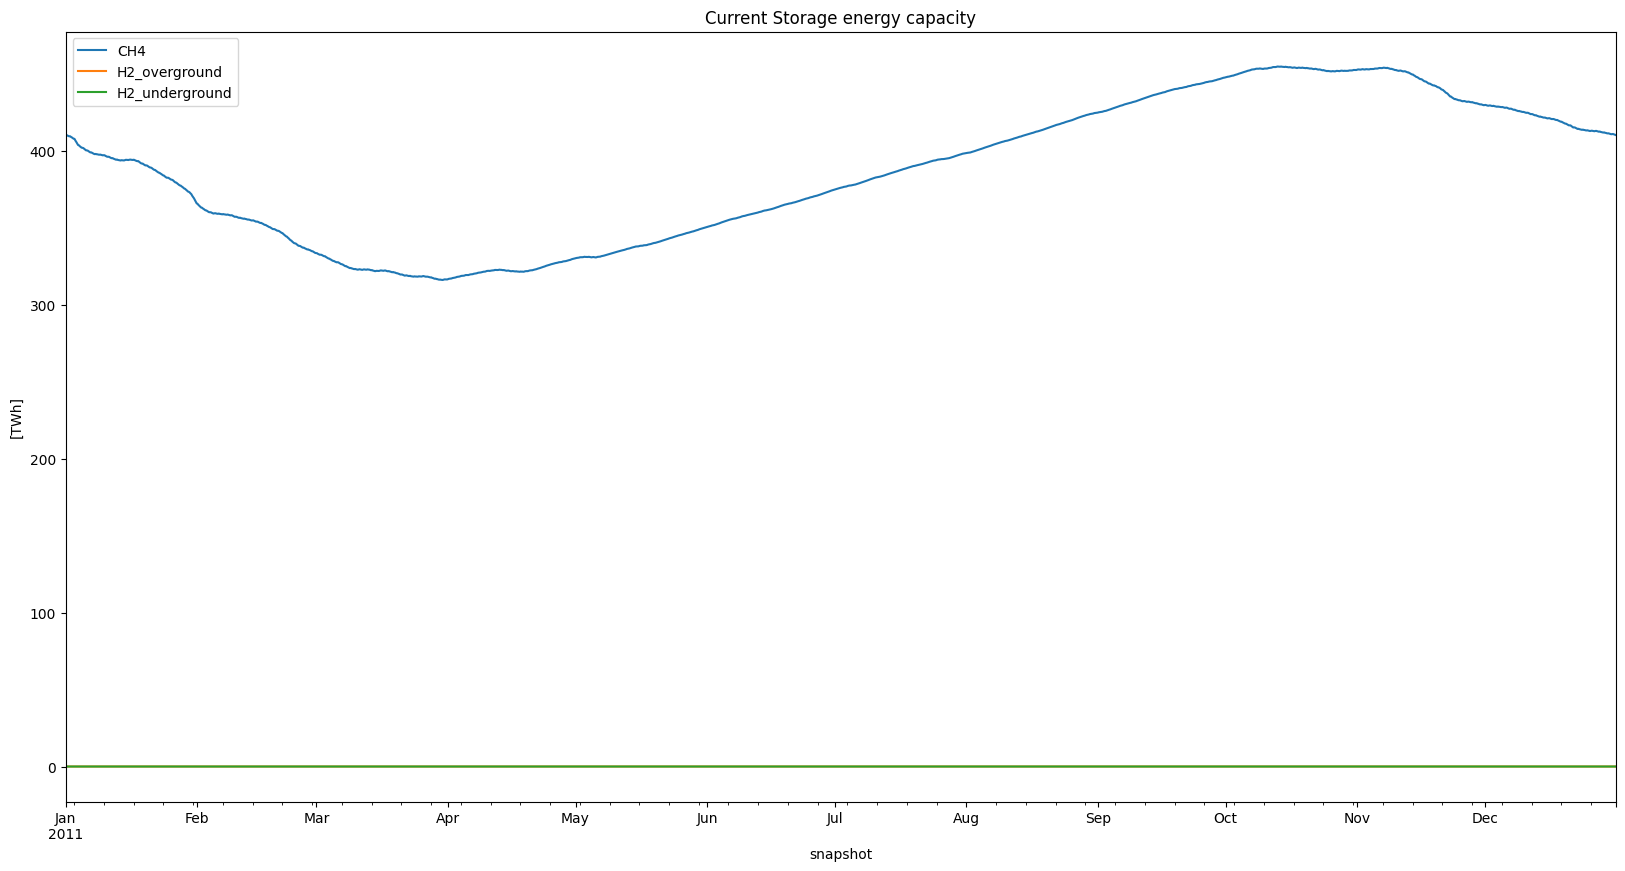

In [24]:
gas_storage_techs = ['CH4', 'H2_overground', 'H2_underground']
for i in gas_storage_techs:
    stores = network.stores.loc[network.stores.carrier == i]
    print(f'{i} total storage capacity:{stores.e_nom_opt.sum()/1e6:.3} TWh')
    print(f'{i} Maximum fill (%): {network.stores_t.e[stores.index].sum(axis = 1).max()/stores.e_nom_opt.sum()*100:.3}')
    (network.stores_t.e[stores.index].sum(axis = 1)/1e6).plot(title = 'Current Storage energy capacity',figsize=(20,10), ylabel='[TWh]',label = i, legend= True)

In [25]:
network.stores.loc[network.stores.carrier=='H2_underground'].e_nom_opt.sum()


0.7592588972376093

In [26]:
f_c = network.links.loc[network.links.carrier == 'H2_to_power'].p_nom_opt.sum()
print(f'Total Fuel Cell capacity: {f_c:.3} MW')

Total Fuel Cell capacity: 0.00142 MW


In [27]:
electrolyzer = network.links.loc[network.links.carrier == 'power_to_H2'].p_nom_opt.sum()/1e3
print(f'Total Elecrtolyzer capacity: {electrolyzer:.3} GW')

Total Elecrtolyzer capacity: 29.4 GW


In [28]:
methanization = network.links.loc[network.links.carrier == 'H2_to_CH4'].p_nom_opt.sum()
print(f'Total Methanization capacity: {methanization:.3} MW')

Total Methanization capacity: 0.00203 MW


In [29]:
h2f = network.links.loc[network.links.carrier == 'H2_feedin'].p_nom_opt.sum()/1e3
print(f'Total H2_feedin capacity: {h2f:.3} GW')

Total H2_feedin capacity: 9.11e+02 GW


In [30]:
network.links.loc[network.links.carrier == 'H2_feedin'].p_nom.sum()/1e3

910.9257984909653

- Neglectable H2 storage Capacities (~0) -> No energy flexibility arising out of H2 technologies
- CH4 Storages show good seasonal behaviour, Only ~61% of available CH4 storage capacity is used
- Neglectable Fuel Cell capacitities (0.00142 MW)
- Electrolyzer capacity at 29.4 GW
- Neglectable methanization capacitities (0.00203 MW)
- H2_feedin capacitiy at 911 GW

# Investigate Heat Sector

In [31]:
gas_boilers = network.links.loc[network.links.carrier == 'rural_gas_boiler']
gas_boilers.p_nom.sum()
### -> between mid October to end of March rural_gas_boiler always work on full capacity
### Does that make sense? Are there heat-loads shedded? Do central_gas_boilers work as flexibility and rural_gas_boiler provide base_loads?

0.0

<AxesSubplot: title={'center': 'Central and rural heat loads'}, xlabel='snapshot', ylabel='[GW]'>

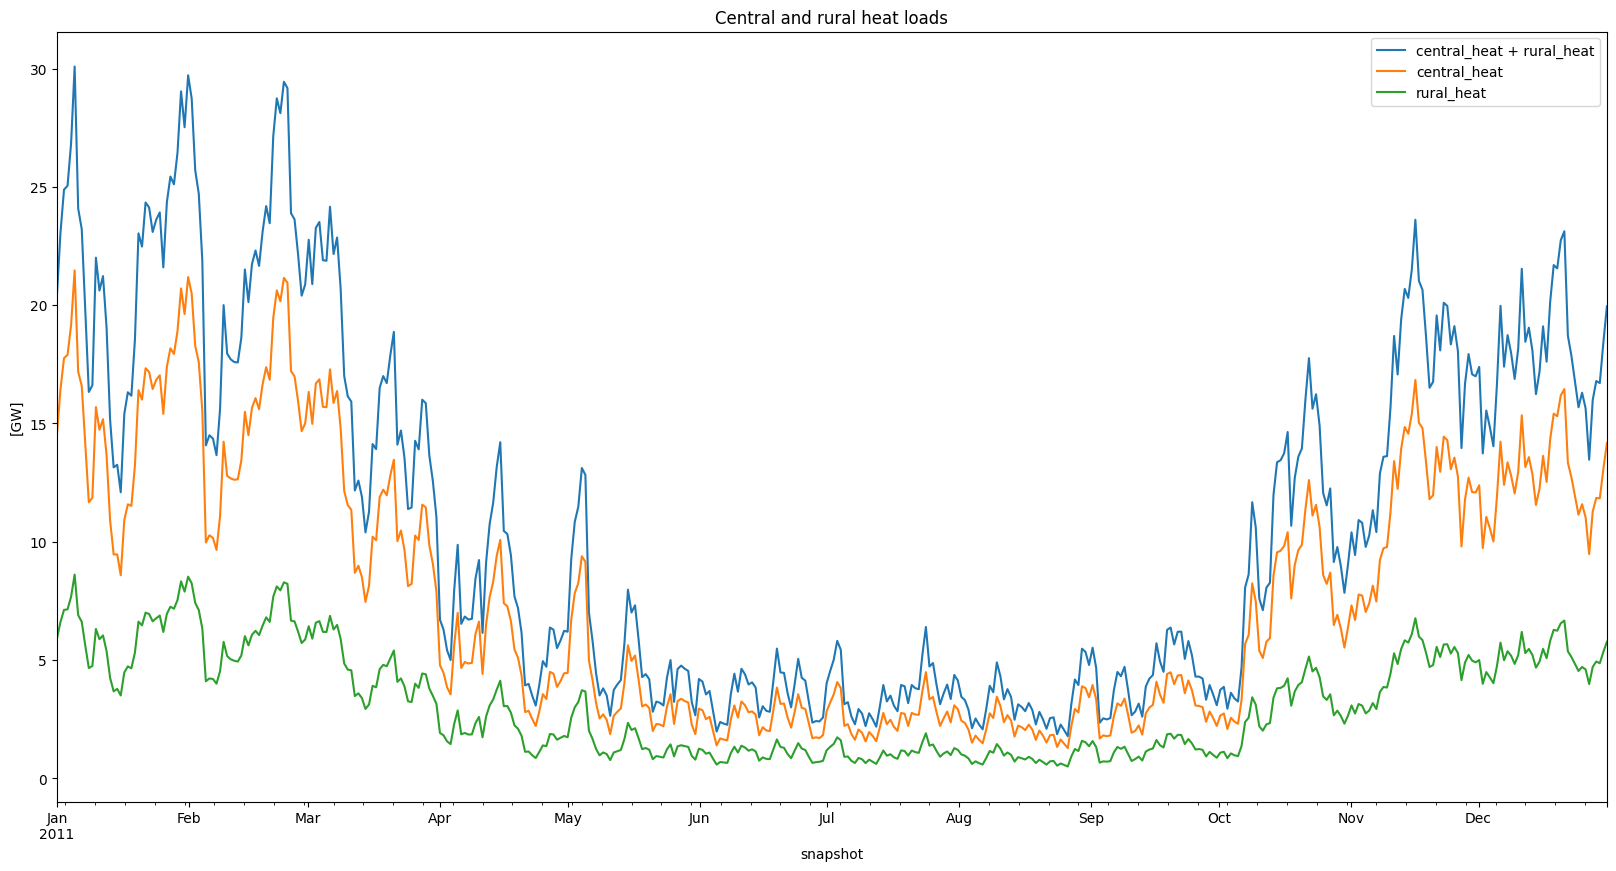

In [32]:
central_h = network.loads.loc[network.loads.carrier == 'central_heat']
rural_h = network.loads.loc[network.loads.carrier == 'rural_heat']
central_h_loads = network.loads_t.p[central_h.index].sum(axis = 1)
rural_h_loads = network.loads_t.p[rural_h.index].sum(axis = 1)

((central_h_loads + rural_h_loads)/1e3).resample('20H').mean().plot(figsize=(20,10), title = 'Central and rural heat loads', label = 'central_heat + rural_heat', legend= True, ylabel='[GW]')
(central_h_loads/1e3).resample('20H').mean().plot(label = 'central_heat', legend= True)
(rural_h_loads/1e3).resample('20H').mean().plot(label = 'rural_heat', legend= True)

### Heat Store Sizes

In [33]:
c_stores = network.stores.loc[network.stores.carrier == 'central_heat_store']
r_stores = network.stores.loc[network.stores.carrier == 'rural_heat_store']
print(f'Total central_heat_stores capacity: {c_stores.e_nom_opt.sum()/1e3} GW')
print(f'Total rural_heat_stores capacity: {r_stores.e_nom_opt.sum()/1e3} GW')

Total central_heat_stores capacity: 767.2299335364444 GW
Total rural_heat_stores capacity: 0.0002617278283342752 GW


- neglectable rural_heat_store capacity

### Heat Store Location

(<matplotlib.collections.PatchCollection at 0x176c619d8b0>,
 <matplotlib.collections.LineCollection at 0x176e2c1e910>)

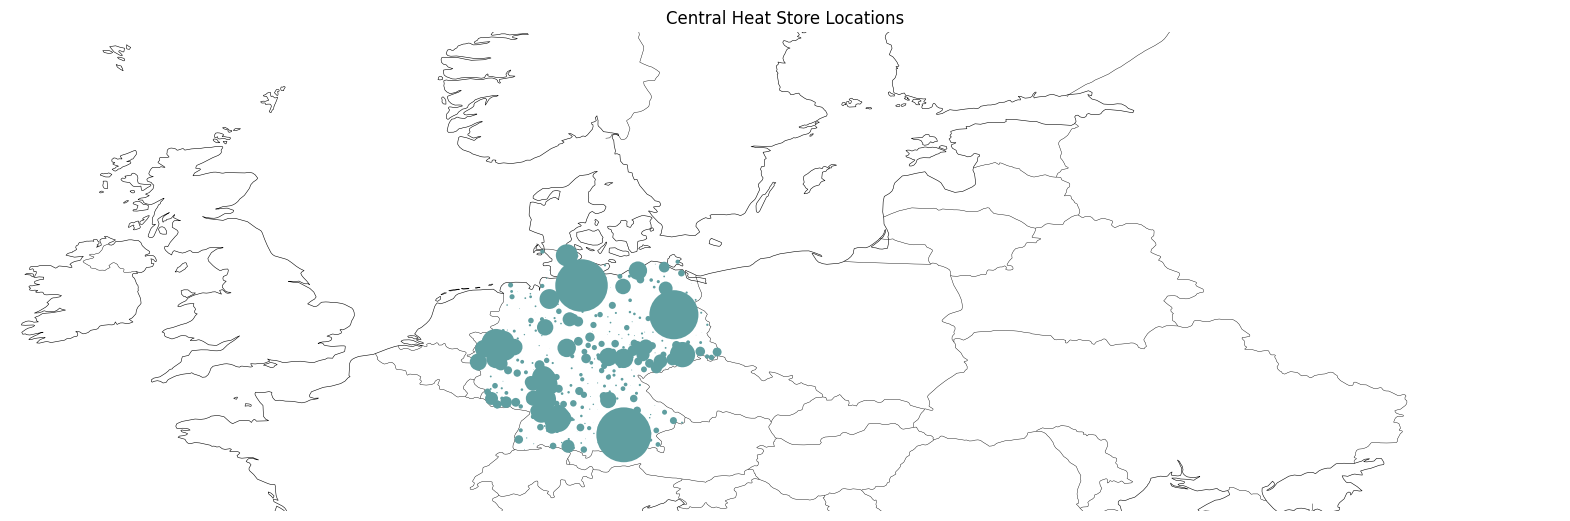

In [34]:
c_stores_capacities = pd.Series(c_stores.e_nom_opt.values, index = c_stores.bus)
scaling = 1/c_stores_capacities.max()

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (20,10))
network.plot(
    bus_sizes=c_stores_capacities*scaling,
    #bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "Central Heat Store Locations")

In [32]:
# Get heat storage dispatch
network.stores.carrier.unique()

array(['CH4', 'central_heat_store', 'rural_heat_store', 'H2_underground',
       'battery storage', 'dsm', 'H2_overground'], dtype=object)

In [47]:
network.generators.carrier.unique()

array(['biomass', 'central_biomass_CHP', 'industrial_biomass_CHP',
       'run_of_river', 'solar', 'solar_rooftop', 'wind_onshore', 'others',
       'reservoir', 'oil', 'wind_offshore', 'coal', 'nuclear', 'lignite',
       'CH4', 'central_biomass_CHP_heat', 'solar_thermal_collector',
       'geo_thermal', 'CH4_biogas', 'CH4_NG', 'load shedding'],
      dtype=object)

In [36]:
# get heat generators
heat_gen_ids = network.generators.loc[network.generators.carrier.isin(['solar_thermal_collector', 'geo_thermal', 'central_biomass_CHP_heat'])].index
heat_gen_dispatch = network.generators_t.p.T.loc[heat_gen_ids].sum(axis=0)

In [39]:
# get heat store dispatch
heat_store_ids = network.stores.loc[network.stores.carrier.isin(['central_heat_store', 'rural_heat_store'])].index
heat_store_dispatch = network.stores_t.p.T.loc[heat_store_ids].sum()

In [40]:
heat_store_dispatch

snapshot
2011-01-01 00:00:00    -338.546893
2011-01-01 05:00:00    -138.015732
2011-01-01 10:00:00       7.827382
2011-01-01 15:00:00       0.400374
2011-01-01 20:00:00     -35.077859
                          ...     
2011-12-30 23:00:00     -13.165454
2011-12-31 04:00:00     650.708957
2011-12-31 09:00:00    3432.898430
2011-12-31 14:00:00    3577.417364
2011-12-31 19:00:00    4113.492951
Length: 1752, dtype: float64

<AxesSubplot: xlabel='snapshot'>

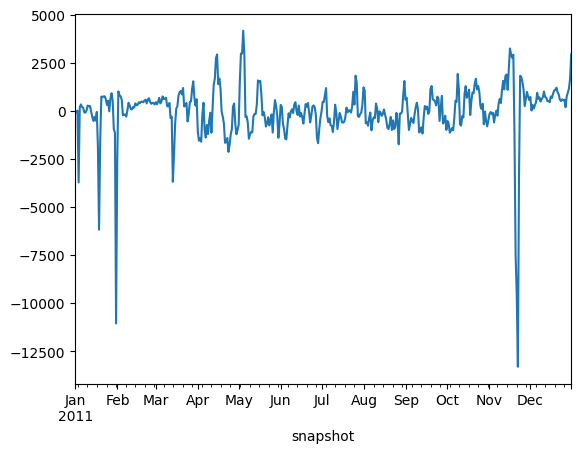

In [41]:
heat_store_dispatch.resample('20H').mean().plot()

<AxesSubplot: title={'center': 'Stacked Heat Generation'}, xlabel='snapshot', ylabel='[MW]'>

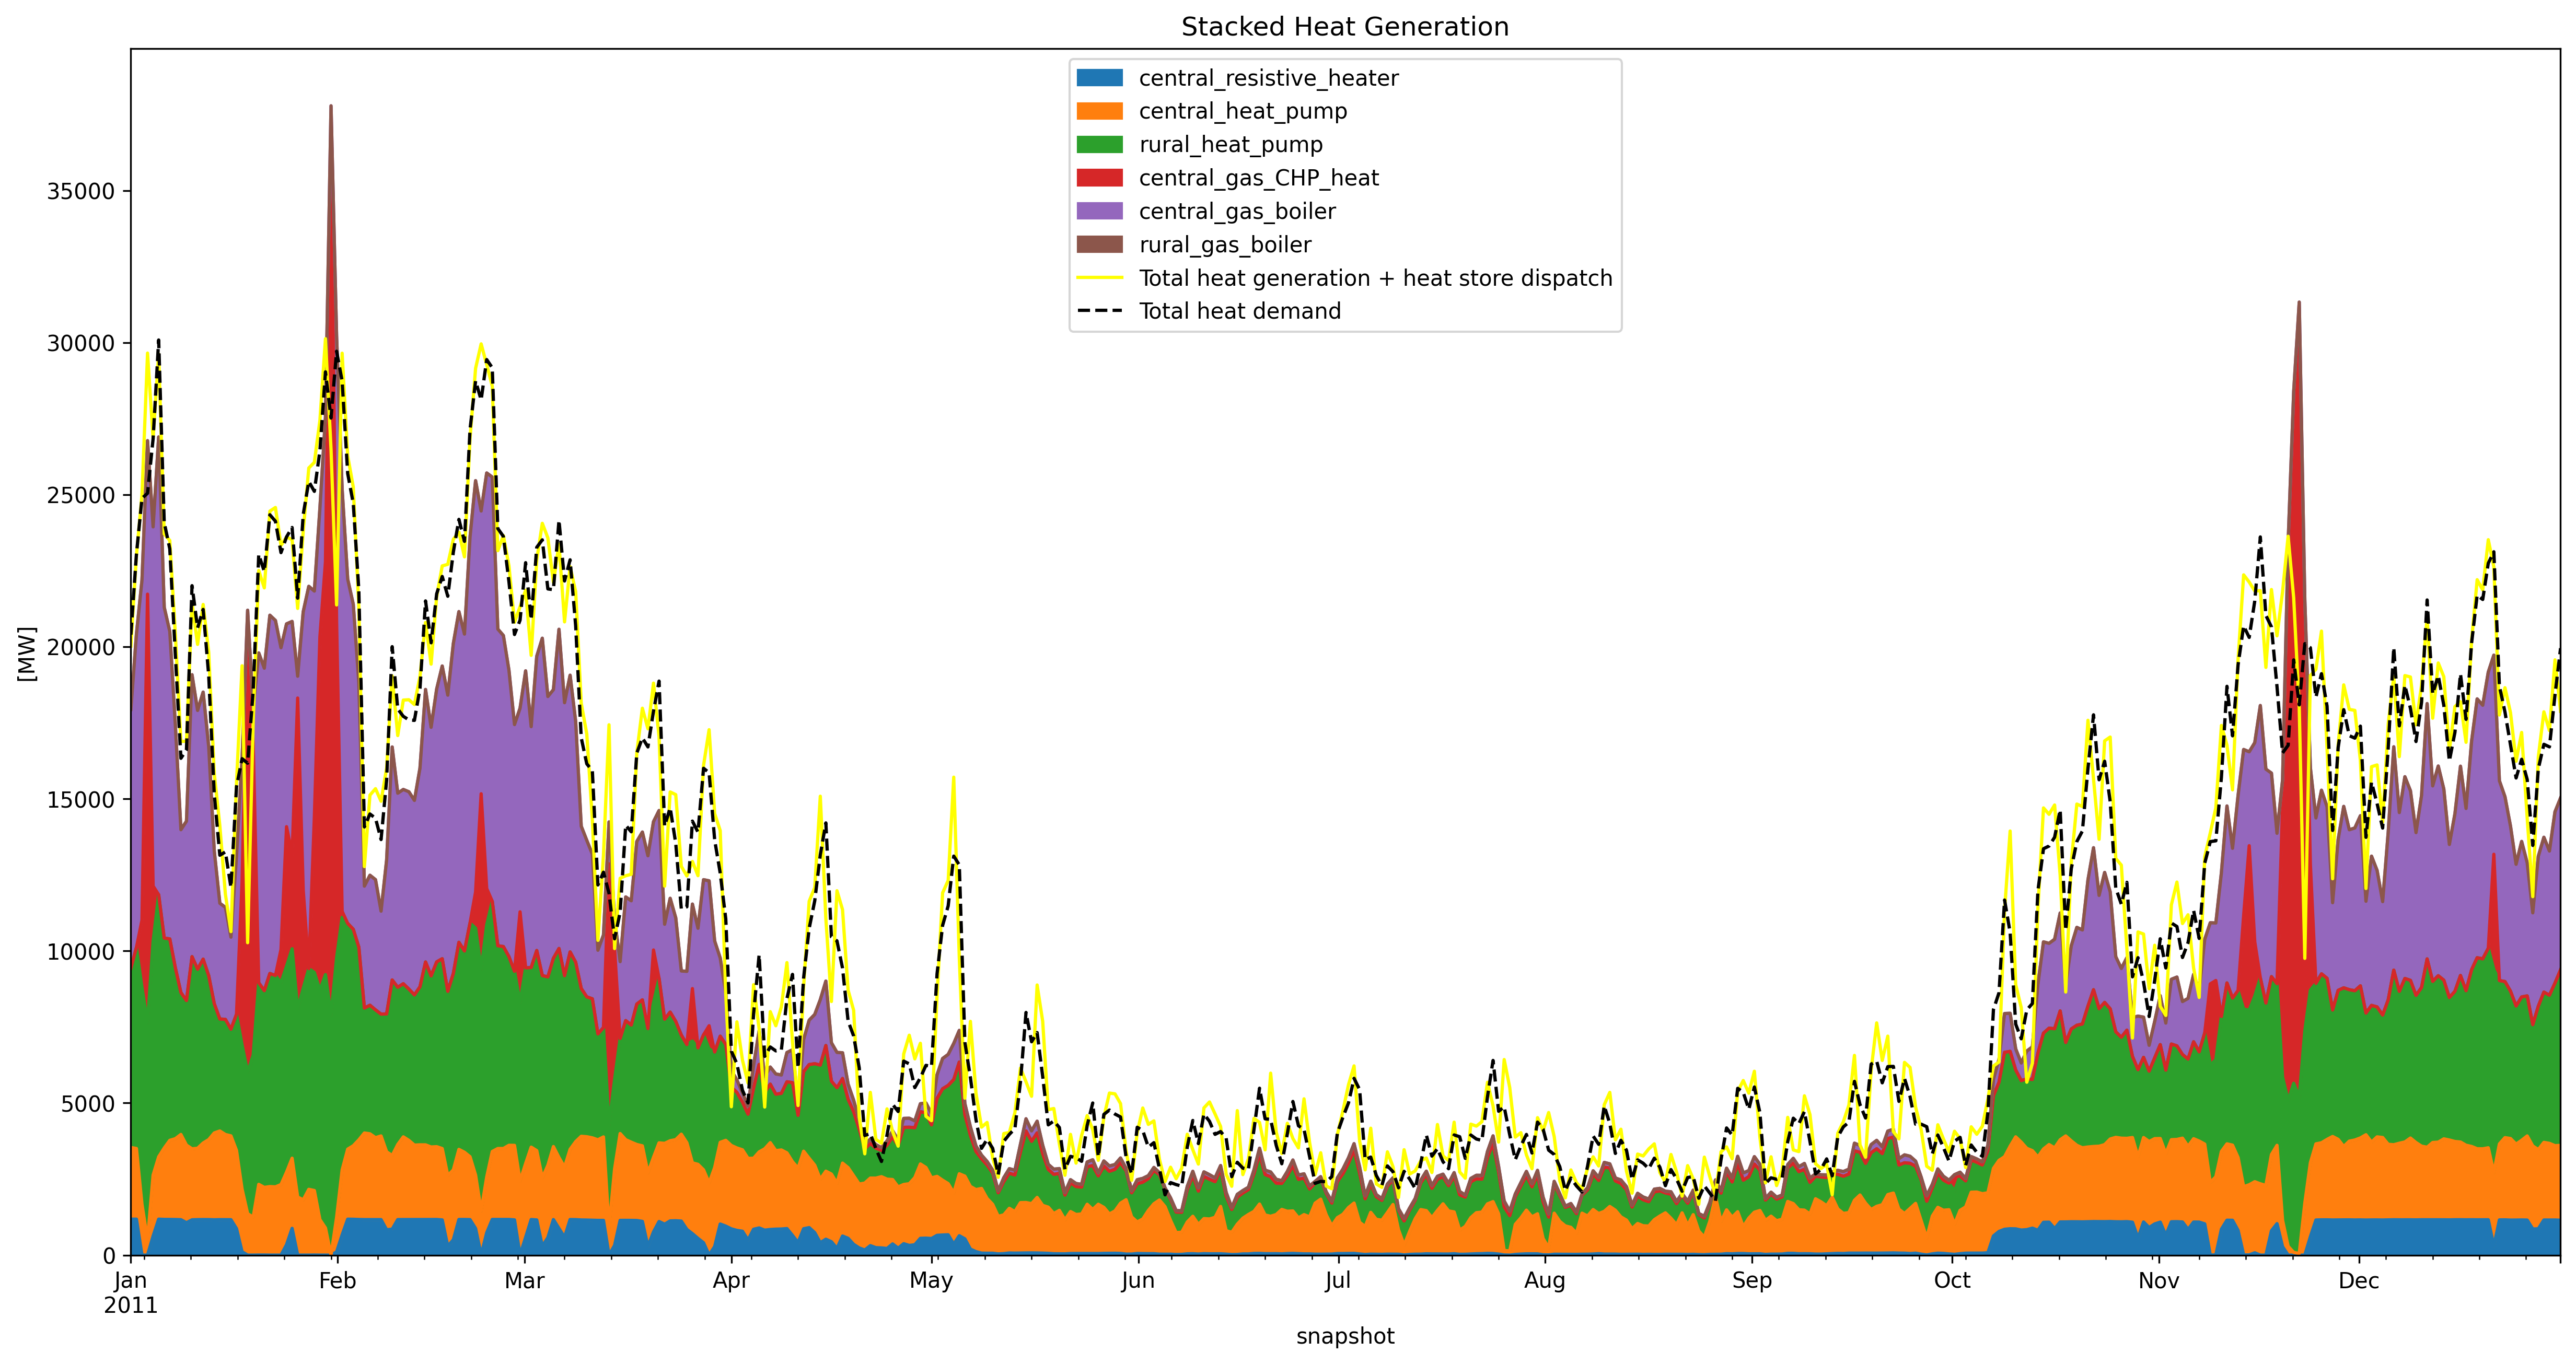

In [42]:
heat_gen_techs = ['central_resistive_heater', 'central_heat_pump', 'rural_heat_pump', 'central_gas_CHP_heat', 'central_gas_boiler', 'rural_gas_boiler']

data = network.links_t.p1[network.links.loc[network.links.carrier == heat_gen_techs[0]].index.to_list()]
data = pd.DataFrame(-(data.sum(axis=1))).resample('20H').mean()
data = data.rename(columns={0:heat_gen_techs[0]})

for i in heat_gen_techs[1:]:
    loads = network.links_t.p1[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = -(loads).sum(axis=1).resample('20H').mean()

fig = plt.figure(figsize=(20, 10), dpi=300)
#(central_h_loads + rural_h_loads).resample('20H').mean().plot(ax = plt.gca(), label='central_heat + rural_heat Loads', legend=True)
data.plot.area(ax = plt.gca(), title='Stacked Heat Generation', ylabel = "[MW]", legend=True, stacked=True)

(data.sum(axis=1) + heat_store_dispatch + heat_gen_dispatch).resample('20H').mean().plot.line(legend=True, label = 'Total heat generation + heat store dispatch',  color = 'yellow')
(central_h_loads + rural_h_loads).resample('20H').mean().plot.line(legend=True, label = 'Total heat demand',  color = 'black', linestyle='dashed')

snapshot
2011-01-01 00:00:00    17937.426411
2011-01-01 20:00:00    20410.188359
2011-01-02 16:00:00    22191.537143
2011-01-03 12:00:00    26774.449534
2011-01-04 08:00:00    23942.258305
                           ...     
2011-12-27 20:00:00    13112.456031
2011-12-28 16:00:00    13736.252851
2011-12-29 12:00:00    13284.507117
2011-12-30 08:00:00    14575.802367
2011-12-31 04:00:00    15027.882194
Freq: 20H, Length: 438, dtype: float64

In [29]:
r_heat_pumps = network.links.loc[network.links.carrier == 'rural_heat_pump']
((r_heat_pumps.p_nom_opt)>0).sum()
#network.links_t.p1[b.index].sum(axis=1).plot()
# werden sie überhaupt gebaut?
# Wieso gibt es mehr r_heat_pumps als AC Busse?

282

In [275]:
network.buses.carrier.value_counts()

AC                    300
dsm                   285
Li ion                285
H2_saltcavern          74
rural_heat             52
rural_heat_store       52
CH4                    42
H2_grid                29
central_heat           29
central_heat_store     29
H2_ind_load            15
Name: carrier, dtype: int64

In [30]:
c_heat_pumps = network.links.loc[network.links.carrier == 'central_heat_pump']
((c_heat_pumps.p_nom_opt)>0).sum()
#network.links_t.p1[b.index].sum(axis=1).plot()
# werden sie überhaupt gebaut?

382

In [31]:
a = network.links.loc[network.links.carrier == 'central_heat_pump']
network.links_t.p1[a.index].sum(axis=1)

snapshot
2011-01-01 00:00:00   -2303.333634
2011-01-01 05:00:00   -2331.166361
2011-01-01 10:00:00   -2387.831587
2011-01-01 15:00:00   -2403.346933
2011-01-01 20:00:00   -2354.887446
                          ...     
2011-12-30 23:00:00   -2389.972927
2011-12-31 04:00:00   -2361.387907
2011-12-31 09:00:00   -2390.256155
2011-12-31 14:00:00   -2533.109976
2011-12-31 19:00:00   -2555.342418
Length: 1752, dtype: float64

<AxesSubplot:xlabel='snapshot'>

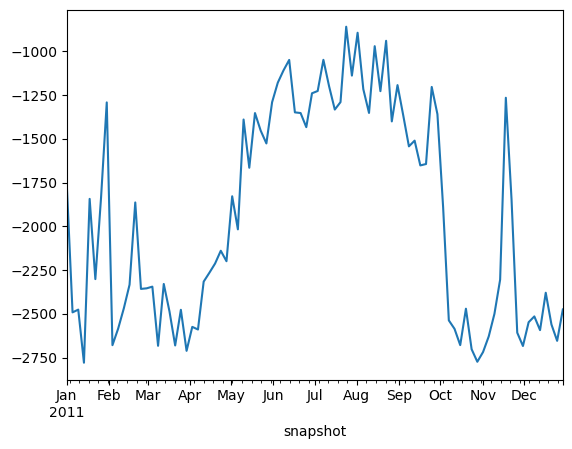

In [32]:
network.links_t.p1[a.index].sum(axis=1).resample('100H').mean().plot()

In [33]:
heat_gen_techs = ['central_resistive_heater', 'central_heat_pump', 'rural_heat_pump', 'central_gas_CHP_heat', 'central_gas_boiler', 'rural_gas_boiler']

data = network.links_t.p1[network.links.loc[network.links.carrier == heat_gen_techs[0]].index.to_list()]
data = pd.DataFrame(-(data.sum(axis=1)))
data = data.rename(columns={0:heat_gen_techs[0]})

for i in heat_gen_techs[1:]:
    loads = network.links_t.p1[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = -(loads).sum(axis=1)

In [34]:
# 'central_heat_store', 'rural_heat_store'
a = network.stores.loc[network.stores.carrier == 'central_heat_store']
b = network.stores.loc[network.stores.carrier == 'rural_heat_store']

<AxesSubplot:xlabel='snapshot'>

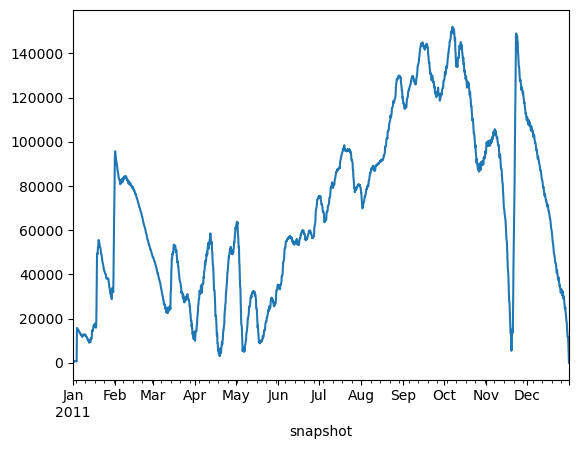

In [35]:
(-network.stores_t.p[a.index].sum(axis=1).cumsum()).plot()

In [36]:
# all heat generated by links
data.sum().sum()

15800488.768490165

In [37]:
(central_h_loads + rural_h_loads).sum()

# looks like there is a 20 TW difference

19104155.87924967

In [154]:
a=network.stores_t.e[[col for col in network.stores_t.e.columns if 'CH4' in col]].sum(axis=1)
a.max()
# data = network.links_t.p0[network.links.loc[network.links.carrier == rel_ch4_loads[0]].index.to_list()]
# data = pd.DataFrame(data.sum(axis=1)).resample('20H').mean()
# data = data.rename(columns={0:rel_ch4_loads[0]})

114896924.9105341

In [ ]:
# Cummulative use of CH4
# direct consumption 
# stores

In [3]:
network.buses = network.buses[network.buses.country == 'DE']# & (network.buses.carrier == 'CH4')]
network.links = network.links[network.links.bus0.isin(network.buses.index) & network.links.bus1.isin(network.buses.index) & (network.links.carrier == 'CH4')]

In [ ]:
PLOT H2 STORAGES ALL ON ONE MAP
PLOT PIE CHART OF STORAGE capacities
PLOT PI CHART OF STORAGE COSTS

In [5]:
H2_overground = network.stores[network.stores.carrier == 'H2_overground']
H2_underground = network.stores[network.stores.carrier == 'H2_underground'] #underground has e_nom_opt=0 for all entries

capacities = H2_overground.e_nom_opt.groupby([network.stores.bus, network.stores.carrier]).sum()
scaling = 1/(max(abs(capacities.groupby(level=0).sum())))

In [108]:
capacities = H2_underground.e_nom_opt.groupby([network.stores.bus, network.stores.carrier]).sum()
scaling = 1/(max(abs(capacities.groupby(level=0).sum())))
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (9,9))
network.plot(
    bus_sizes=capacities * scaling,
    bus_colors=colors(),
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "Optimised CH4 generation")


NameError: name 'H2_underground' is not defined

In [6]:
capacities2 = H2_overground.e_nom_opt.groupby([network.stores.bus, network.stores.carrier]).sum()+100

(<matplotlib.collections.PatchCollection at 0x28390de8948>,
 <matplotlib.collections.LineCollection at 0x283946ed208>)

C:\ProgramData\mambaforge\envs\etrago\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\ProgramData\mambaforge\envs\etrago\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


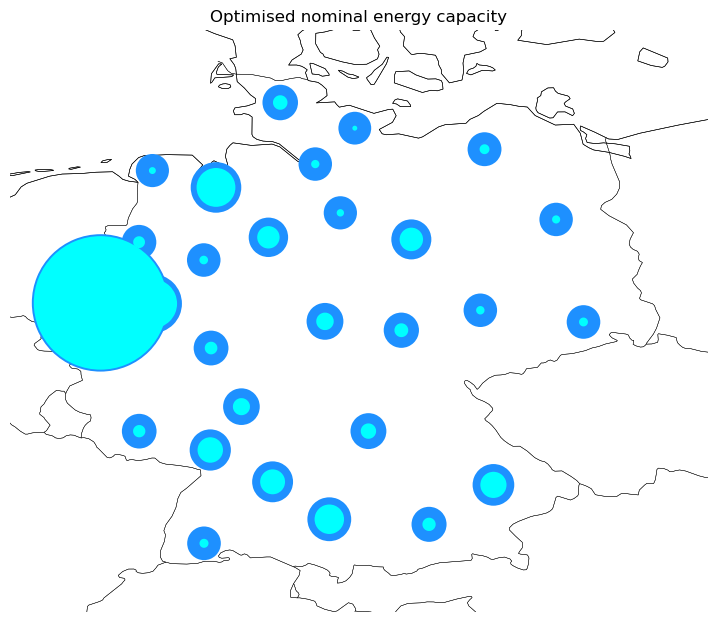

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (9,9))
colors = tools.plot.coloring()
colors2 = coloring2()
network.plot(
    bus_sizes=capacities2 * scaling,
    bus_colors=colors2,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,)

network.plot(
    bus_sizes=capacities * scaling,
    bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "Optimised nominal energy capacity")





In [97]:
capacities2

bus    carrier      
77860  H2_overground     417.910569
77861  H2_overground     616.328548
77862  H2_overground    1664.948392
77863  H2_overground     466.244164
77864  H2_overground    7290.661376
77865  H2_overground    1001.080502
77866  H2_overground     943.023643
77867  H2_overground    1685.249363
77868  H2_overground     798.480725
77869  H2_overground    1690.547424
77870  H2_overground     156.998191
77871  H2_overground    3027.610087
77872  H2_overground     288.931335
77873  H2_overground     634.607175
77874  H2_overground     630.504440
77875  H2_overground     737.383522
77876  H2_overground     249.126160
Name: e_nom_opt, dtype: float64

In [ ]:
tools.plot.nodal_gen_dispatch(etrago.network, techs=['wind_onshore'])